# Inference of parameters (SIR model)
In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given the full data (of classes S, Ia, Is) from a generated trajectory.


In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pyross
import time 

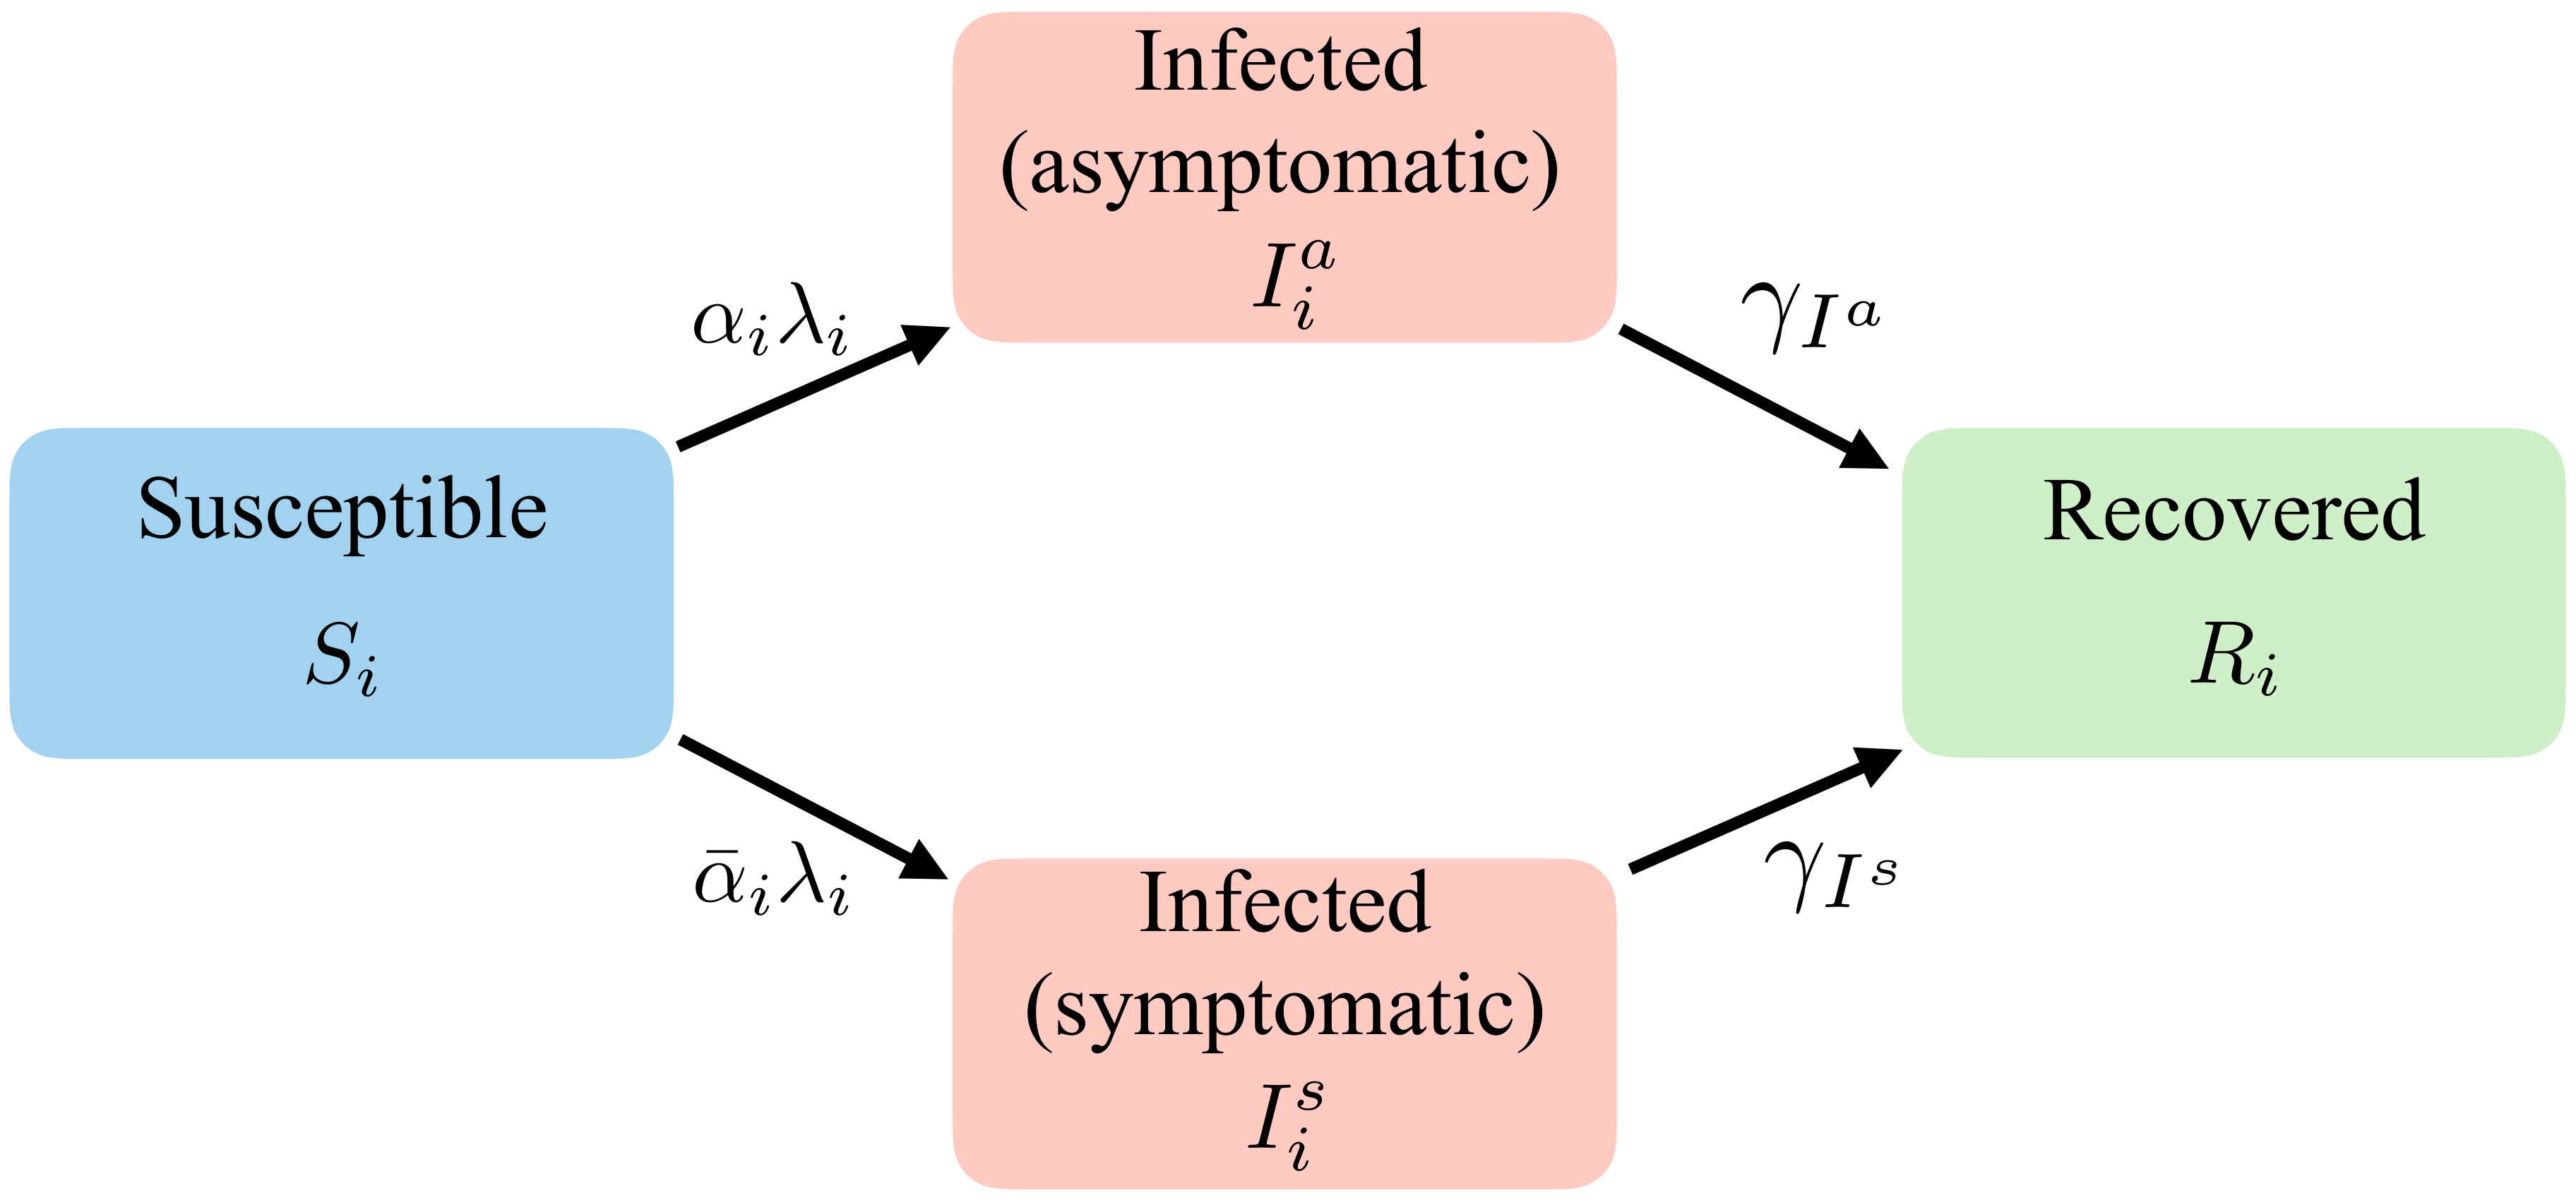

In [2]:
from IPython.display import Image
Image('https://raw.githubusercontent.com/rajeshrinet/pyross/d2b38651d4d1569f0b10d1780aa01a55c5c89170/examples/inference/SIIR.jpg')

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [3]:
M = 2                # the population has two age groups
N = 1e6              # and this is the total population

# parameters for generating synthetic trajectory 
beta  = 0.02         # infection rate
gIa   = 1./7         # recovery rate of asymptomatic infectives
gIs   = 1./7         # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 1          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], 
              [3., 12.]]) 
# C_ij = number of people group from group i that an individual from group j meets per day 

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([2, 2])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf, method='tau-leaping')
data_array = data['X']
np.save('SIR_sto_traj.npy', data_array)

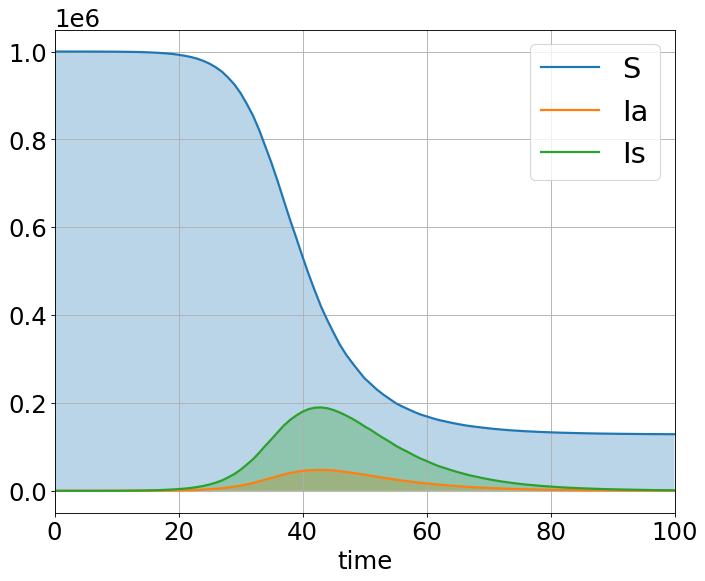

In [4]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=2)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## 2) Inference
We take the first $20$ data points of the trajectories and use it to infer the parameters of the model.

In [5]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('SIR_sto_traj.npy').astype('float')
x = (x)[:Nf_inference]

estimator = pyross.inference.SIR(parameters, M, Ni)

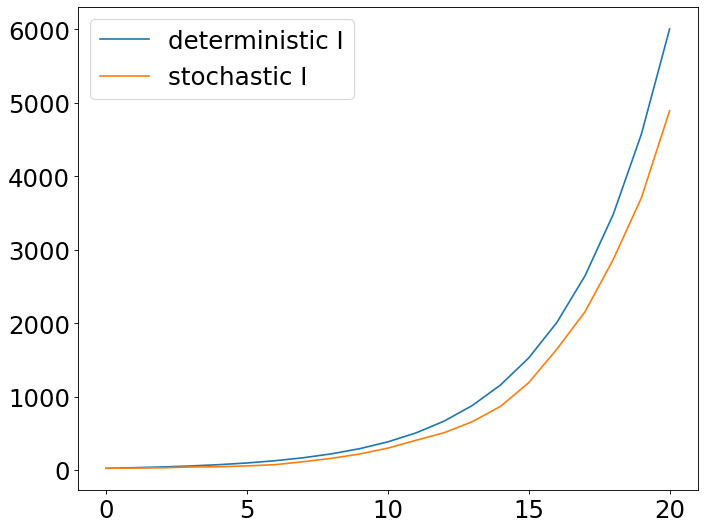

In [6]:
# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
x0=x[0]
estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)
xm = estimator.integrate(x[0], 0, Tf_inference, Nf_inference)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(xm[:, M:], axis=1), label='deterministic I')
plt.plot(np.sum(x[:Nf_inference, M:], axis=1), label='stochastic I')
plt.legend()
plt.show()

In [7]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use faster ODE methods to speed up inference 
estimator.set_lyapunov_method('euler')
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, contactMatrix, tangent=False)
end_time = time.time()
print(logp) 
print(end_time - start_time)

380.02871294534924
0.02140974998474121


In [8]:
# compare to tangent space 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, contactMatrix, tangent=True)
end_time = time.time()
print(logp) 
print(end_time - start_time)

401.73265060077523
0.002165555953979492


In [9]:
# Define the prior (log normal prior around guess of parameter with defined std. deviation)
alpha_g = 0.25
beta_g = 0.04
gIa_g = 0.1
gIs_g = 0.1


# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g, 'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, contactMatrix)
print(logp) 

2986.533794555463


In [10]:
# Set up priors 
eps = 1e-4
priors = {
    'alpha':{
        'mean': alpha_g, 
        'std': 0.2, 
        'bounds': [eps, 0.8], 
        'prior_fun': 'truncnorm'
    }, 
    'beta':{
        'mean': beta_g, 
        'std': 0.1, 
        'bounds': [eps, 0.2], 
        'prior_fun': 'lognorm'
    }, 
    'gIa':{
        'mean': gIa_g, 
        'std': 0.2, 
        'bounds': [eps, 0.6]
    }, 
    'gIs':{
        'mean': gIs_g, 
        'std': 0.2, 
        'bounds': [eps, 0.6]
    }
}

# Stopping criterion for minimisation (realtive change in function value)
ftol = 1e-6  
start_time = time.time() 
res = estimator.infer_parameters(x, Tf_inference, contactMatrix, priors, tangent=False, 
                                    global_max_iter=20, local_max_iter=400,
                                    cma_population=32, global_atol=10,
                                    ftol=ftol, verbose=True)
end_time = time.time()

print(res['map_dict']) # best guess 
print(end_time - start_time)

Starting global minimisation ...
         Switching to single processed mode (cma_processes = 1).
(16_w,32)-aCMA-ES (mu_w=9.2,w_1=19%) in dimension 4 (seed=364937138, Tue Apr 19 13:30:50 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     32 7.354047133718933e+02 1.0e+00 9.05e-01  5e-02  2e-01 0:00.5
    2     64 6.702205774675377e+02 1.4e+00 8.15e-01  4e-02  2e-01 0:00.9
    3     96 5.471268281436115e+02 1.6e+00 8.26e-01  3e-02  2e-01 0:01.4
   11    352 3.810250986644093e+02 1.5e+01 3.63e-01  1e-03  8e-02 0:04.5
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  375.65794249471674
Starting local minimisation...
Optimal value (local minimisation):  375.56482348566306
{'alpha': 0.2072994175151327, 'beta': 0.02004310465283492, 'gIa': 0.16055840579521968, 'gIs': 0.136847997127137, 'fsa': array([1., 1.])}
9.111671686172485


In [11]:
# compute log_p for best estimate 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(res['map_dict'], x, Tf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

379.6563639614419
0.015331268310546875


In [12]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(res['map_dict'])

print(res['flat_map'])

True parameters:
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

Inferred parameters:
{'alpha': 0.2072994175151327, 'beta': 0.02004310465283492, 'gIa': 0.16055840579521968, 'gIs': 0.136847997127137, 'fsa': array([1., 1.])}
[0.20729942 0.0200431  0.16055841 0.136848  ]


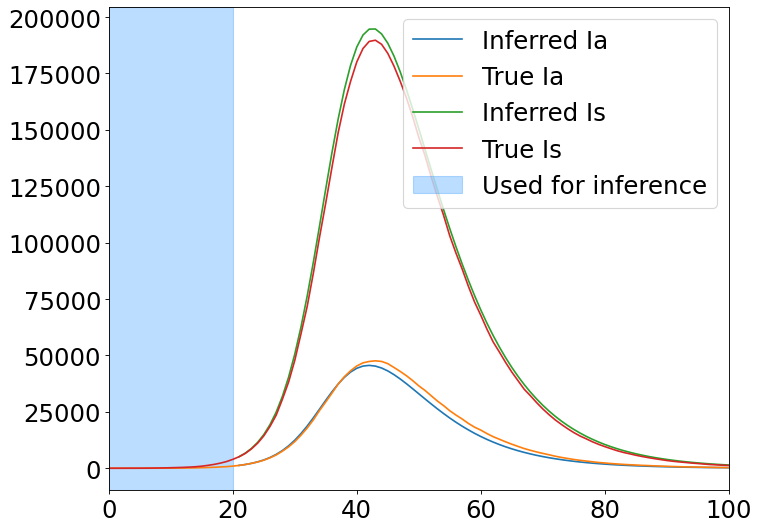

In [13]:
x = np.load('SIR_sto_traj.npy').astype('float')
Nf = x.shape[0]
Tf = Nf-1

# set the deterministic method to be solve_ivp for accurate integration over long time scale 
estimator.set_det_model(res['map_dict'])
estimator.set_params(res['map_dict'])

x_det = estimator.integrate(x[Nf_inference], Nf_inference, Tf, Nf-Nf_inference)
t_inf = np.linspace(Nf_inference, Tf, Nf-Nf_inference)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
# plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
# plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(t_inf, np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(t_inf, np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Is')
plt.xlim([0, Tf])
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 

In [14]:
eps = 1e-3
x = np.load('SIR_sto_traj.npy').astype('float')[:Nf_inference]
hess = estimator.hessian(x, Tf_inference, res, contactMatrix=contactMatrix, eps=eps, tangent=False,
                                 fd_method="central")

epsilon used for differentiation:  0.001


In [15]:
cov = np.linalg.inv(hess)
print(cov)
v, w = np.linalg.eig(cov)
print(v)

[[ 4.46957382e-04 -6.07605476e-08  8.58343494e-04 -2.28716315e-04]
 [-6.07605476e-08  4.39416693e-08 -1.19948792e-07  3.14898299e-08]
 [ 8.58343494e-04 -1.19948792e-07  1.77816881e-03 -4.62017513e-04]
 [-2.28716315e-04  3.14898299e-08 -4.62017513e-04  1.32932176e-04]]
[2.32024587e-03 2.66578438e-05 1.11546550e-05 4.39333243e-08]


## From here onwards,  still work in process (need to update Forecast module)

In [16]:
parameters = res['map_dict'].copy() 
parameters['fsa'] = fsa
parameters['cov'] = cov 

# Initialise pyross forecast module
model_forecast = pyross.forecast.SIR(parameters, M, Ni)



In [17]:
# Initial condition for forecast is last configuration from inference-trajectory
S0_forecast = x[Tf_inference,:M]
Ia0_forecast = x[Tf_inference,M:2*M]
Is0_forecast = x[Tf_inference,2*M:]
print(Ia0_forecast, Is0_forecast)

# Number of simulations over which we average, use 500
Ns = 500

Tf_forecast = Tf - Tf_inference
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(S0_forecast, Ia0_forecast, Is0_forecast, 
                                          contactMatrix, Tf_forecast, Nf_forecast,
                                          verbose=True, method='deterministic',
                                          Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t'] + Tf_inference

[471. 482.] [1971. 1969.]


Finished. Time needed for evaluation: 00:00:00


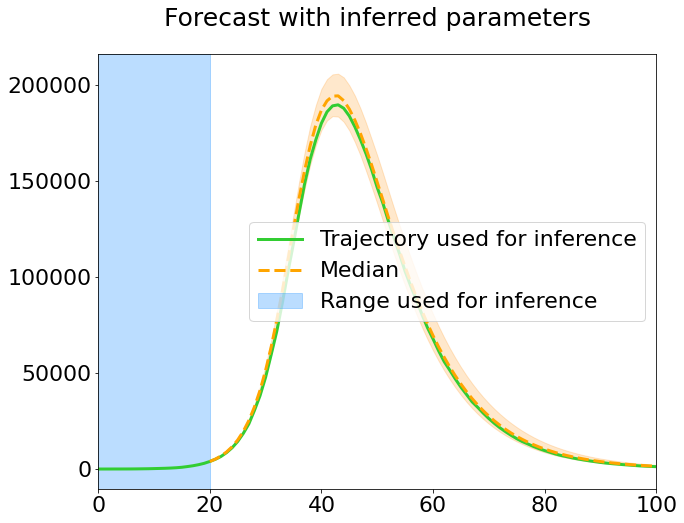

In [18]:
fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = trajectories_forecast[:,4] + trajectories_forecast[:,5]
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)

cur_trajectory_underlying = data_array[:,4] + data_array[:,5]

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
# for i,e in enumerate(cur_trajectories_forecast):
#     ax.plot(t_forecast,e,
#             alpha=0.15,
#            )

ax.fill_between(t_forecast, percentiles_lower, percentiles_upper, color='darkorange', alpha=0.2)
ax.plot(cur_trajectory_underlying,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
plt.legend()
plt.xlim([0, Tf])
plt.show()